In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
downloaded = drive.CreateFile({'id':'18IGSf-O0z_YurrVmf_EWWf6Q-pvDUXgz'}) # replace the id with id of file you want to access
downloaded.GetContentFile('imdb_master.csv') 
downloaded = drive.CreateFile({'id':'1yfqgNc03UCQqouAjQ4Rqjk2B559G5dC1'}) # replace the id with id of file you want to access
downloaded.GetContentFile('labeledTrainData.tsv') 
downloaded = drive.CreateFile({'id':'1N59zjZ7LqpPkS5YK8WtPahr0Tt-GMKPI'}) # replace the id with id of file you want to access
downloaded.GetContentFile('testData.tsv') 

In [ ]:
import pandas as pd
df2 = pd.read_csv('imdb_master.csv',encoding="latin-1") 
df1 = pd.read_csv('labeledTrainData.tsv',header=0,delimiter='\t',quoting=3) 
test=pd.read_csv('testData.tsv',header=0,delimiter='\t',quoting=3)

In [ ]:
df2=df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns=['review','sentiment']
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [ ]:
df1=df1.drop(['id'],axis=1)
df1.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment']=df2['sentiment'].map({'neg':0,'pos':1})
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [ ]:
df2.shape

(50000, 2)

In [ ]:
import pandas as pd
df=pd.concat([df1,df2]).reset_index(drop=True)
df.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


(array([37500.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 37500.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

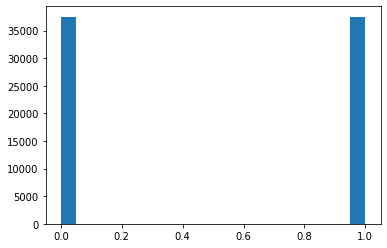

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['sentiment'],bins=20)

Text(0, 0.5, 'frequency')

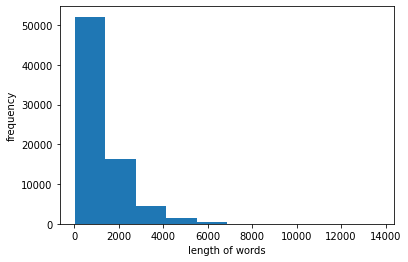

In [ ]:
leng=0
length = [(leng + len(x)) for x in df['review']]
plt.hist(length)
plt.xlabel('length of words')
plt.ylabel('frequency')

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')
 
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df.head()

,sentiment,review,Processed_Reviews
0,1,"""With all this stuff going down at the moment ...",stuff go moment mj ive start listen music watc...
1,1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war world timothy hines entertain film...
2,0,"""The film starts with a manager (Nicholas Bell...",film start manager nicholas bell give welcome ...
3,0,"""It must be assumed that those who praised thi...",must assume praise film greatest film opera ev...
4,1,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious 80 ex...


In [ ]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

128.53272

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,Sequential
from keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation,GRU,Flatten
from keras.layers import Bidirectional,GlobalMaxPool1D
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers


max_features=6000
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train=tokenizer.texts_to_sequences(df['Processed_Reviews'])


max_len=150
x_train=pad_sequences(list_tokenized_train,maxlen=max_len)
y_train=df['sentiment']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.3,random_state=42)

embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size=100
epochs=5
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 52500 samples, validate on 22500 samples
Epoch 1/5
52500/52500 [==============================] - 171s 3ms/step - loss: 0.3364 - accuracy: 0.8556 - val_loss: 0.2555 - val_accuracy: 0.8974
Epoch 2/5
52500/52500 [==============================] - 154s 3ms/step - loss: 0.2067 - accuracy: 0.9208 - val_loss: 0.2368 - val_accuracy: 0.9072
Epoch 3/5
52500/52500 [==============================] - 153s 3ms/step - loss: 0.1519 - accuracy: 0.9457 - val_loss: 0.2289 - val_accuracy: 0.9161
Epoch 4/5
52500/52500 [==============================] - 155s 3ms/step - loss: 0.1065 - accuracy: 0.9643 - val_loss: 0.2382 - val_accuracy: 0.9188
Epoch 5/5
52500/52500 [==============================] - 158s 3ms/step - loss: 0.0746 - accuracy: 0.9778 - val_loss: 0.2737 - val_accuracy: 0.9203


In [ ]:
model=Sequential()
model.add(Embedding(max_features,embed_size))
model.add(Bidirectional(LSTM(128,recurrent_dropout=0.1)))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

batch_size=128
epochs=2
history=model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.25)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 39375 samples, validate on 13125 samples
Epoch 1/2
39375/39375 [==============================] - 450s 11ms/step - loss: 0.3637 - accuracy: 0.8376 - val_loss: 0.2827 - val_accuracy: 0.8829
Epoch 2/2
39375/39375 [==============================] - 452s 11ms/step - loss: 0.2438 - accuracy: 0.9050 - val_loss: 0.2763 - val_accuracy: 0.8878


In [ ]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators = 100) 

forest = forest.fit(x_train, y_train )
result = forest.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

accuracy=accuracy_score(y_test,result)
accuracy

0.70856

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix 

y_pred_log = model.predict_classes(x_test)


acc=accuracy_score(y_test,y_pred_log)
print("The accuracy is {}".format(acc))

prec = precision_score(y_test,y_pred_log) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_test,y_pred_log) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_test,y_pred_log) 
print("The F1-Score is {}".format(f1))

MCC = matthews_corrcoef(y_test,y_pred_log) 
print("The Matthews correlation coefficient is {}".format(MCC)) 

The accuracy is 0.9203111111111111
The precision is 0.9312557286892759
The recall is 0.9068999375167366
The F1-Score is 0.91891647447203
The Matthews correlation coefficient is 0.8408874092690934


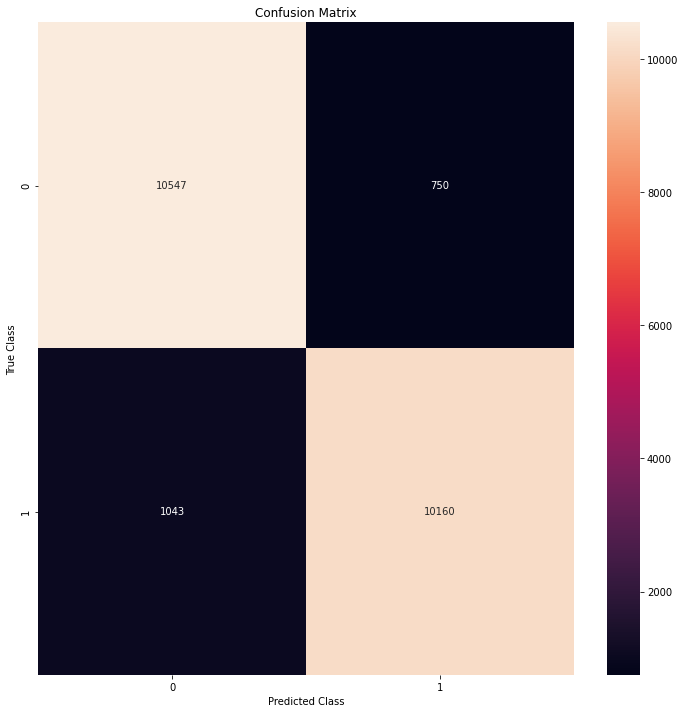

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix=confusion_matrix(y_test,y_pred_log)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix,annot=True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [ ]:
test["review"]=test.review.apply(lambda x: clean_text(x))
test.head()

,id,review
0,"""12311_10""",naturally film main theme mortality nostalgia ...
1,"""8348_2""",movie disaster within disaster film full great...
2,"""5828_4""",movie kid saw tonight child love one point kid...
3,"""7186_2""",afraid dark leave impression several different...
4,"""12128_7""",accurate depiction small time mob life film ne...


In [ ]:
max_features=6000
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(test['review'])
list_tokenized_train=tokenizer.texts_to_sequences(test['review'])

test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test =test["sentiment"]

max_len=150
x_test=pad_sequences(list_tokenized_train,maxlen=max_len)
predictions=model.predict(x_test)

predictions = [1 if (x>0.5) else 0 for x in predictions ]
predictions = pd.Series(predictions)

ids = test['id'].str.replace('"', '')

submission = pd.DataFrame({'id': ids, 'sentiment':predictions})



In [ ]:
submission.head(5)
submission.to_csv( "submission.csv", index=False, quoting=3 )

In [ ]:
from google.colab import files
files.download("submission.csv")